# Overview

In [1]:
#File Name: Figure_2A.ipynb
#Author: Matthias M. Fischer
#Last Revision: 20th April 2022
#Changelog: Initial Version.

#This file contains the complete commented source code
#for reproducing all plots from Figure 2A of the manuscript
#by Fischer and Blüthgen.

# Setup

In [5]:
# Library imports

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp

In [6]:
# Convenience function:
# Return the maximum real part of all
# eigenvalues of a given matrix M

def lambdamax(M):
    return np.max(np.real(np.linalg.eigvals(M)))

In [7]:
# Return the coefficient matrix A describing
# the model where all NSCC compartments
# dedifferentiate

def A(K_C=1.0,                                        # CSC cycling rate
      K_N=1.0,                                        # NSCC cycling rate
      K_T=0.05,                                       # Dedifferentiation rate
      P_S=0.18,                                       # Probability CSC doubling
      P_A=0.82,                                       # Probability CSC asymmetric doubling
      P_D=0,                                          # Probability CSC double differentiation
      D_C=0.05,                                       # CSC apoptosis rate
      D_N=0.05,                                       # NSCC apoptosis rate
      M=7):                                           # Number NSCC compartments
    
    beta = (P_S-P_D)*K_C - D_C                        # CSC compartment net growth rate
    iota = (P_A + 2*P_D)*K_C                          # Influx rate compartment N_1, in multiples of C(t)
 
    A = np.zeros((M+1, M+1))                          # Initialise coefficient matrix A
    A[0,0] = beta                                     # A_{1,1} := beta
    A[1,0] = iota                                     # A_{2,1} := iota
    
    for i in range(1, M+1):                           # A_{1,i} := K_T for i in [2...M]
        A[0,i] = K_T
    
    for i in range(1, M):                             # A_{i,i} := -K_N - K_T - D_N for i in [1,M-1]
        A[i,i] = -K_N - K_T - D_N
    
    A[M,M] = -K_T - D_N                               # A_{M+1, M+1} := -K_T - D_N
    
    for i in range(2,M+1):                            # A_{i, i-1} := 2*K_N for i in [2, M]
        A[i,i-1] = 2*K_N
        
    return A

# Figure 2A, middle panel

In [10]:
# Helper function
# Calculate the NCSC apoptosis rate N_C_crit required to achieve
# negative tumour growth under standard parametrisation
# for a given dedifferentiation rate K_T.
# This will always return +infinity, as shown analytically

def D_N_critical(K_T):
    f = lambda D_N: lambdamax(A(K_T=K_T, D_N=D_N))
    if (f(0)<0) & (f(100)<0):
        return 0
    elif (f(0)>0) & (f(100)>0):
        return 1000
    else:
        return sp.optimize.bisect(f, 0, 100)

Text(0, 0.5, '$\\mathrm{NSCC \\ Apoptosis \\ Rate \\ } D_N \\ [d^{-1}]$')

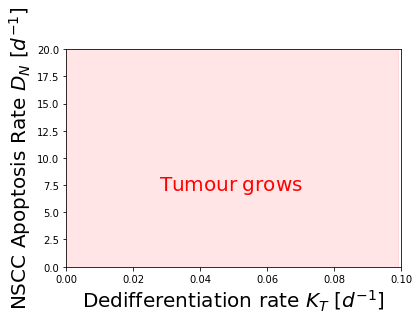

In [13]:
# Calculate D_C_crit as a function of K_T
K_T = np.arange(0, 0.1,0.001)
D_N_crit = list(map(D_N_critical, K_T))

# Plot, shade, annotate
plt.plot(K_T, D_N_crit, label="$K_T=0.01$", lw=2)
plt.fill_between(K_T, 0, D_N_crit, color="red", alpha=.1)
plt.text(0.0275, 7, "$\mathrm{Tumour \; grows}$", color="red", fontsize=20)

# Labels, limits
plt.xlim((0, 0.1))
plt.ylim((0, 20))
plt.xlabel(r"$\mathrm{Dedifferentiation \ rate \ } K_T \ [d^{-1}]$", fontsize=20)
plt.ylabel(r"$\mathrm{NSCC \ Apoptosis \ Rate \ } D_N \ [d^{-1}]$", fontsize=20)


# Figure 2A, right panel

Text(0, 0.5, '$\\mathrm{Population \\; Size \\; [a.u.]}$')

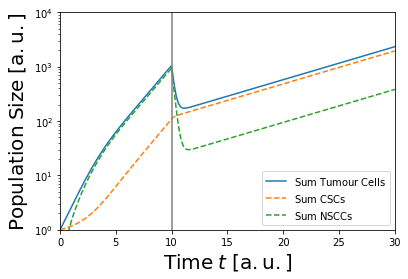

In [5]:
# Treatment onset at t>=10:
# Increase NSCC apoptosis to 5.0 d^-1
def system(t, y):
    if t > 10:
        return A(D_N=5, K_T=0.05).dot(y)
    else:
        return A(K_T=0.05).dot(y)

# Solve system numerically
sol = solve_ivp(system, t_span=[0, 30], y0=[1,0,0,0,0,0,0,0], max_step=.1)

# Plot
CSCs = sol.y[0]
NSCCs = [np.sum(x) for x in list(zip(*sol.y[1:8]))]
plt.plot(sol.t, CSCs+NSCCs, c="C0", label="$\mathrm{Sum \; Tumour \; Cells}$")
plt.plot(sol.t, CSCs, c="C1", ls="--", label="$\mathrm{Sum \; CSCs}$")
plt.plot(sol.t, NSCCs, c="C2", ls="--", label="$\mathrm{Sum \; NSCCs}$", )

# Labels, limits, legend, etc.
plt.legend(loc="lower right", fontsize=10)
plt.vlines([10], 1, 1e7, color="grey", ls="-")
plt.yscale("log")
plt.xlim((0,30))
plt.ylim((1,1e4))
plt.xlabel(r"$\mathrm{Time \; } t \mathrm{\; [a.u.]}$", fontsize=20)
plt.ylabel(r"$\mathrm{Population \; Size \; [a.u.]}$", fontsize=20)
